# Obtaining a training dataset

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import xarray as xr
import dask
from dask.distributed import Client

from modules import stats
from modules import regridding

In [62]:
client = Client(n_workers=8, threads_per_worker=1, memory_limit='12GB')
client

<Client: 'tcp://127.0.0.1:37595' processes=8 threads=8, memory=89.41 GiB>

## Temporal autocorrelation

In [3]:
data = xr.open_mfdataset('../data/control/1024_192/*.nc')
data = data.isel(t=(data.t <= 300)).drop_duplicates('t')

In [ ]:
max_lag = 10.
lag_step = 0.2
u_corr = stats.autocorrelation(data.u, 't', max_lag, lag_step).compute()
w_corr = stats.autocorrelation(data.w, 't', max_lag, lag_step).compute()
theta_corr = stats.autocorrelation(data.theta, 't', max_lag, lag_step).compute()

In [18]:
autocorrelation = xr.merge([u_corr, w_corr, theta_corr])
autocorrelation.attrs['Start time'] = '0'
autocorrelation.attrs['End time'] = '300'
autocorrelation.to_netcdf('../data/control/1024_192/autocorrelation.nc')

[Text(0.5, 0, 'Lag'), Text(0, 0.5, 'Spatially averaged autocorrelation')]

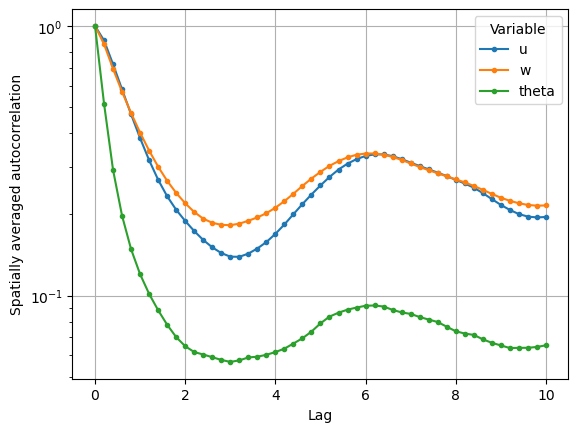

In [14]:
fig, ax = plt.subplots()
for array, label in zip([u_corr, w_corr, theta_corr], ['u', 'w', 'theta']):
    ax.semilogy(array.t_lag, array.mean('x').integrate('z'), label=label, marker='.')

ax.legend(title='Variable')
ax.grid()
ax.set(xlabel='Lag', ylabel='Spatially averaged autocorrelation')

## Subgrid tendencies

1. Run model at fine resolution, saving a pair of states separated by one time step every 3 time units
2. Coarse-grain the first state in each pair and advance it by one time step using the 256 x 192 model

### 1024 x 192 vs. 256 x 192

In [2]:
fine_t = xr.open_mfdataset('../data/training/1024x192_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/1024x192_tplusdt/*.nc')
coarse_t = xr.open_mfdataset('../data/training/256x192_from_1024x192_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/256x192_from_1024x192_tplusdt/*.nc')

In [3]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

regridder = regridding.Regridder(
    fine_t, coarse_t, limits={'z': (0, 1)}, periods={'x': 8})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = regridder(fine_tend.compute()) - coarse_tend.compute()

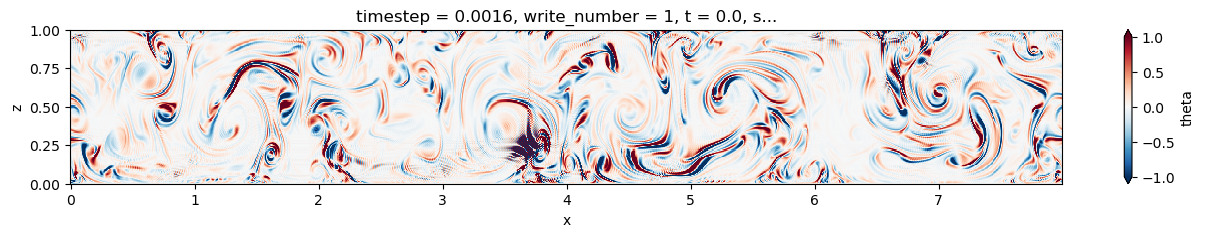

In [116]:
fine_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

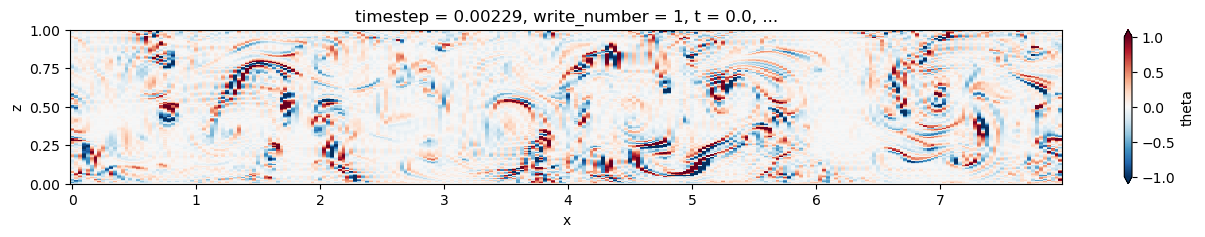

In [ ]:
coarse_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

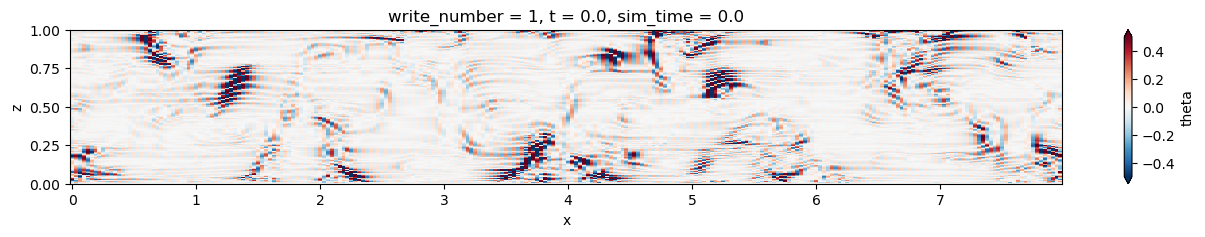

In [118]:
subgrid_tend.theta.isel(t=0).plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

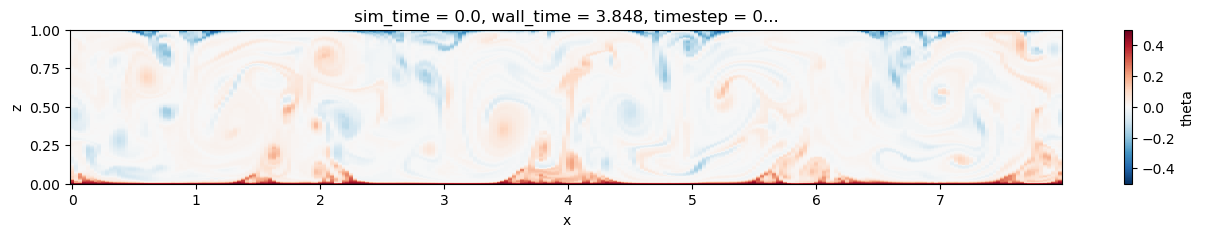

In [122]:
coarse_t.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

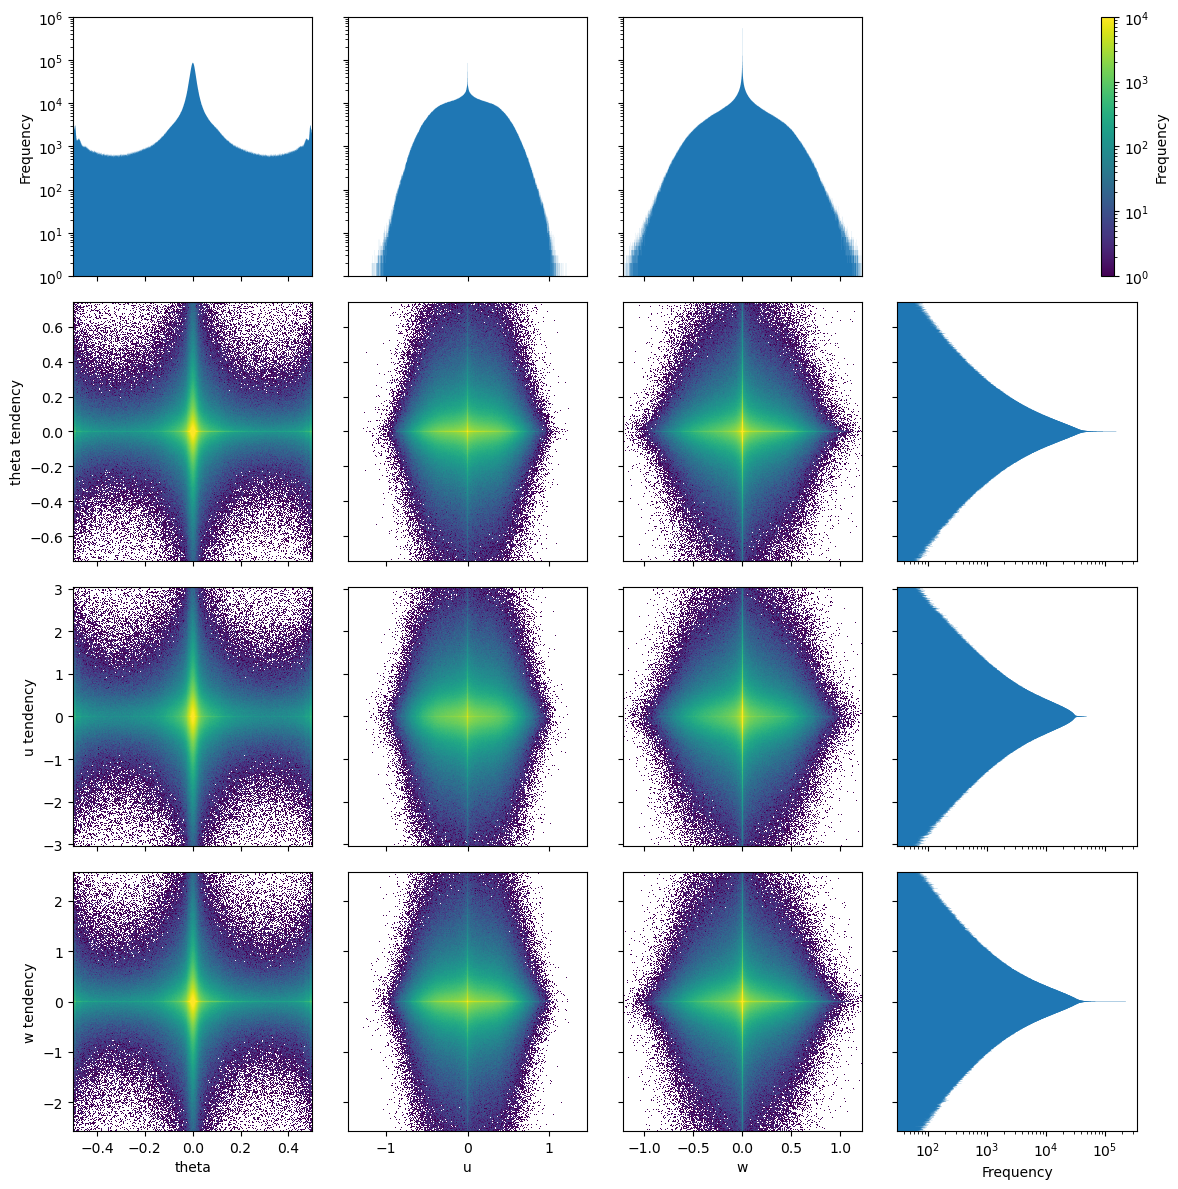

In [112]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 4000
hist2d_nbins = 500
n_std = 5

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = subgrid_tend[tend_var].data.ravel()
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].data.ravel().compute()
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e4
        )

        axes[i+1,3].hist(
            tend_data, bins=hist1d_nbins, orientation='horizontal',
            range=(-tend_lim, tend_lim), color='tab:blue',
            histtype='stepfilled', log=True
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e6)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

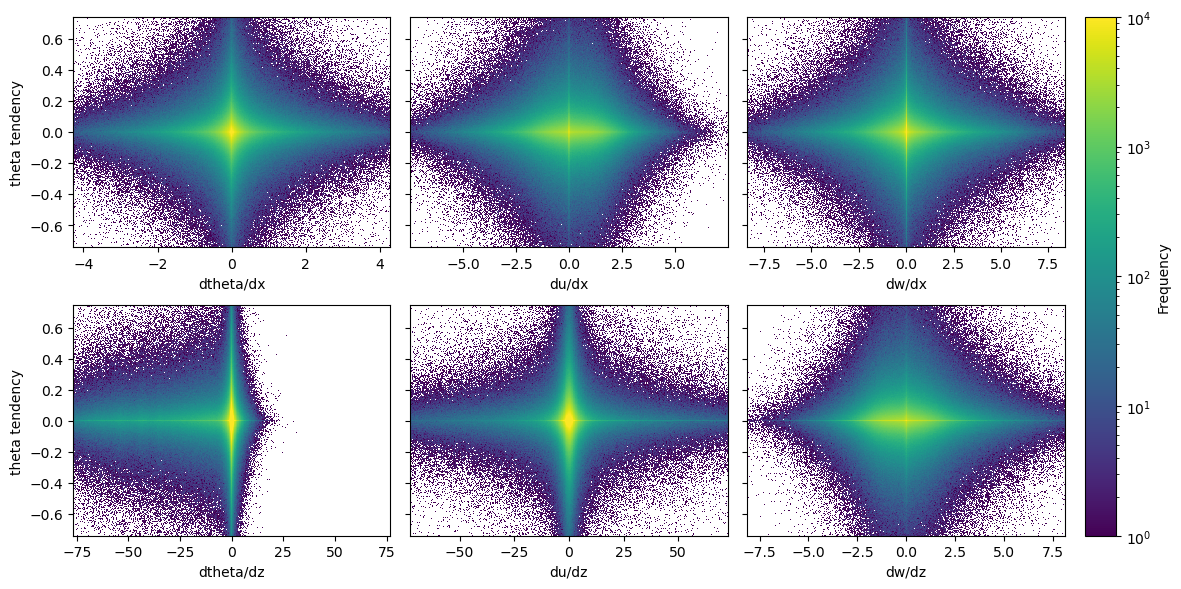

In [10]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 500
n_std = 5

tend_var = 'theta'
tend_data = subgrid_tend[tend_var].data.ravel()
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].differentiate(coord).data.ravel().compute()
        state_lim = n_std*state_data.std()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e4
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### 2048 x 256 vs. 512 x 192

In [11]:
fine_t = xr.open_mfdataset('../data/training/2048x256_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/2048x256_tplusdt/*.nc')
coarse_t = xr.open_mfdataset('../data/training/512x192_from_2048x256_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/512x192_from_2048x256_tplusdt/*.nc')

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

In [12]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

regridder = regridding.Regridder(
    fine_t, coarse_t, limits={'z': (0, 1)}, periods={'x': 8})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = regridder(fine_tend.compute()) - coarse_tend.compute()

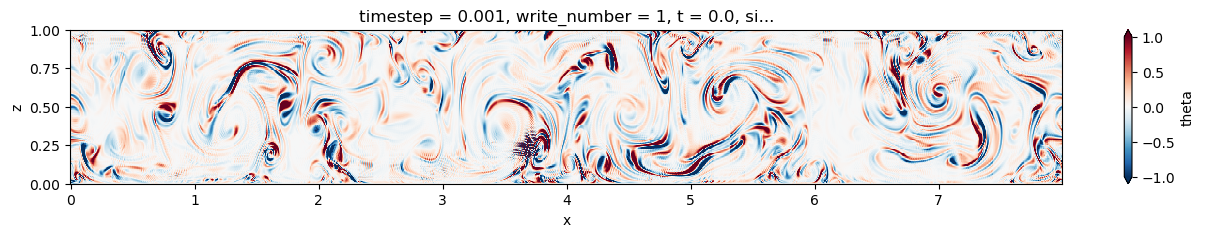

In [20]:
fine_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

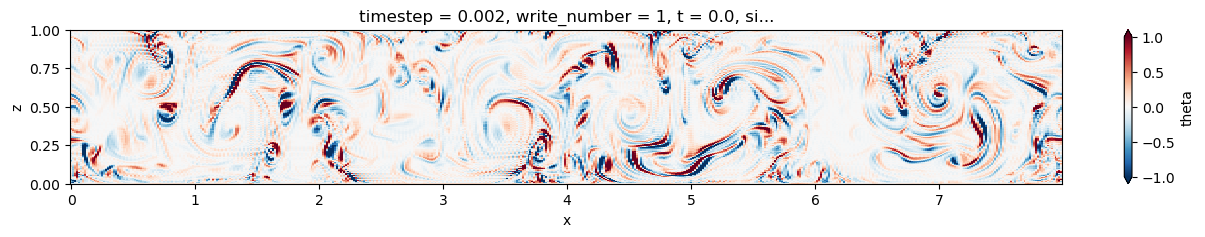

In [22]:
coarse_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

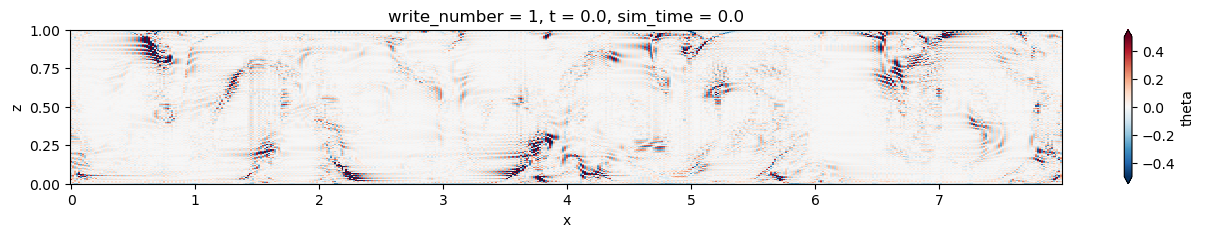

In [25]:
subgrid_tend.theta.isel(t=0).plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

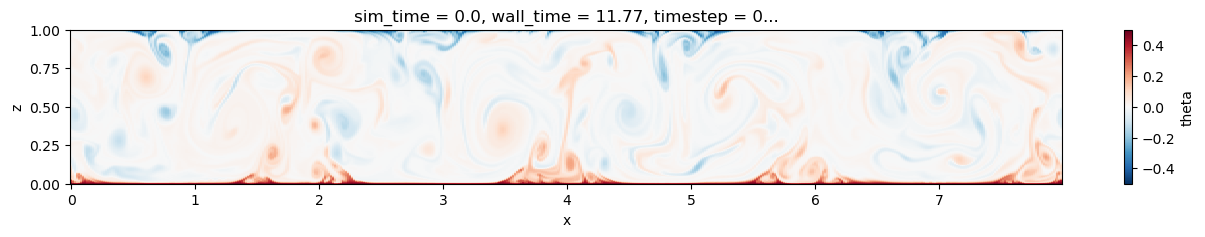

In [26]:
coarse_t.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

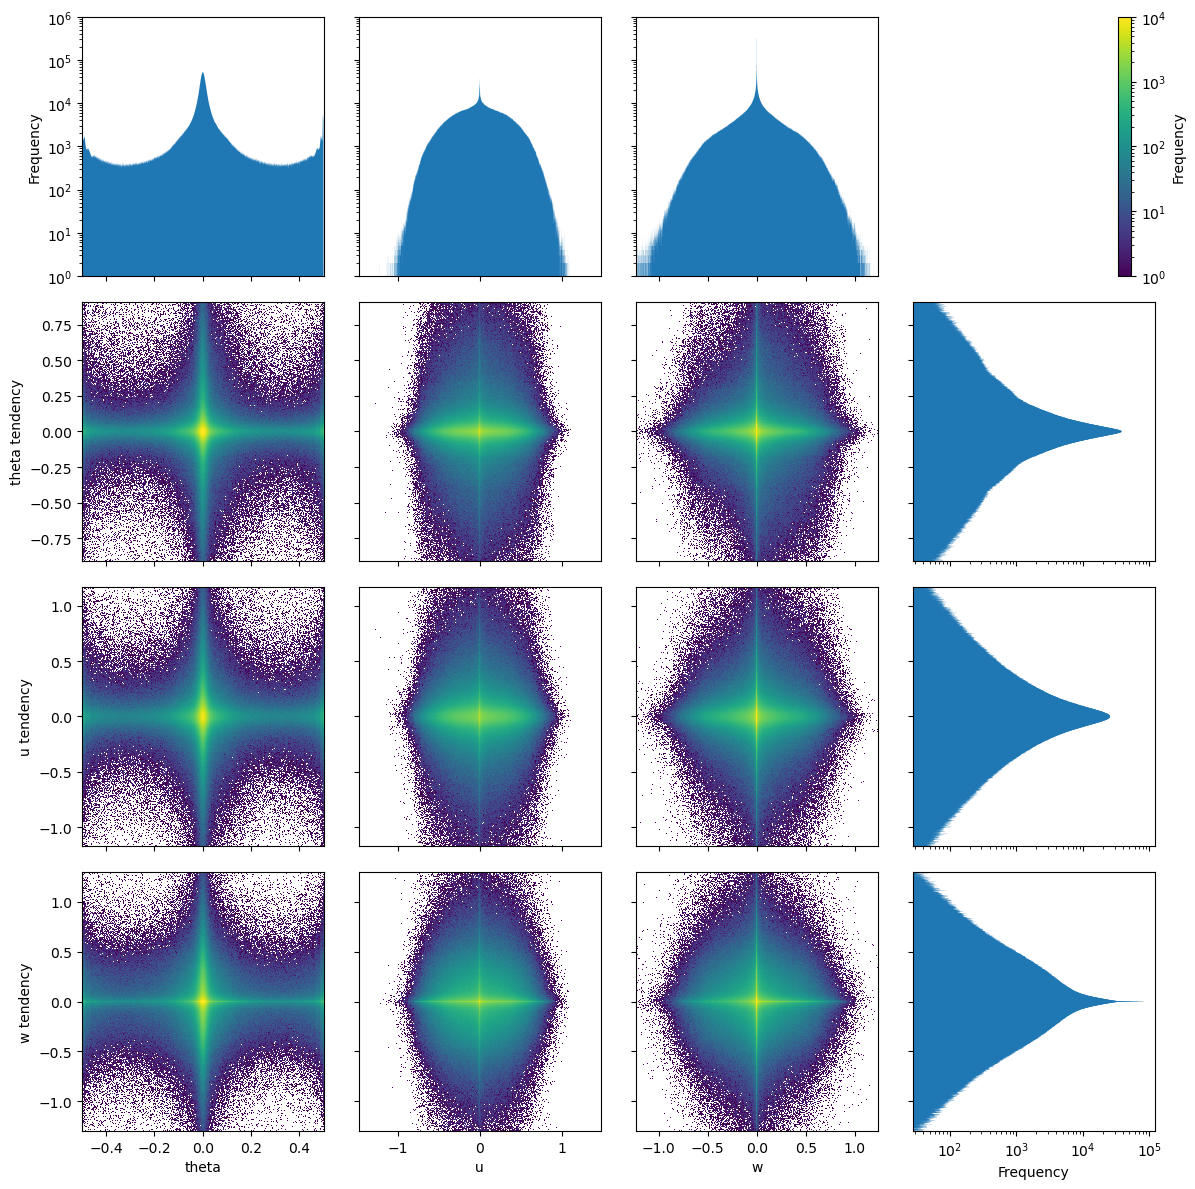

In [31]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 4000
hist2d_nbins = 500
n_std = 5

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = subgrid_tend[tend_var].data.ravel()
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].data.ravel().compute()
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e4
        )

        axes[i+1,3].hist(
            tend_data, bins=hist1d_nbins, orientation='horizontal',
            range=(-tend_lim, tend_lim), color='tab:blue',
            histtype='stepfilled', log=True
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e6)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

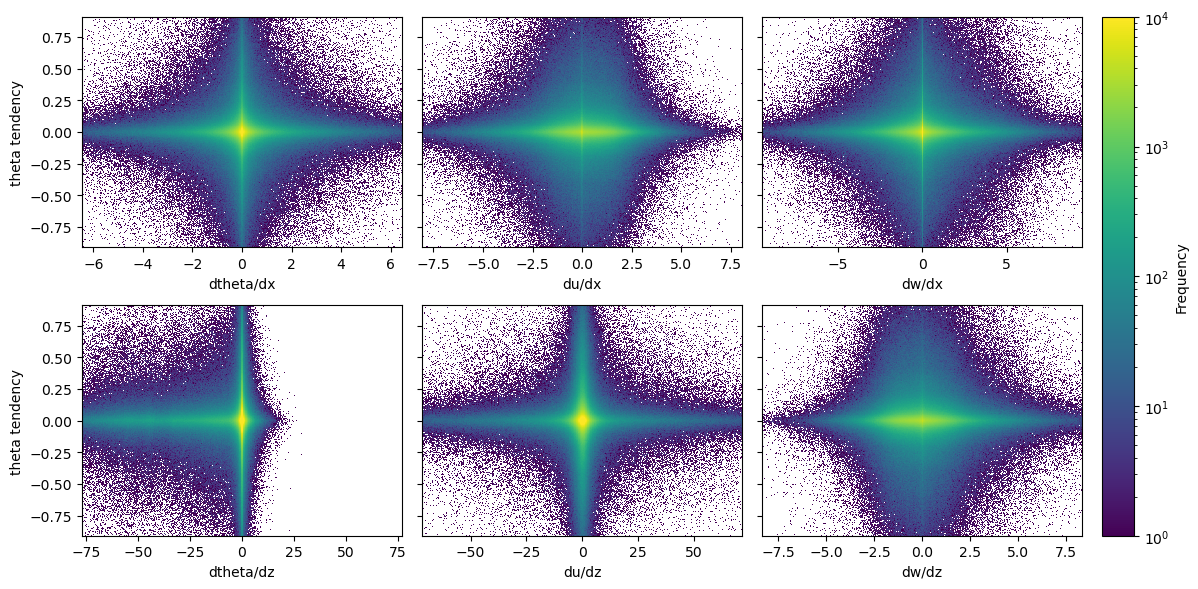

In [13]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 500
n_std = 5

tend_var = 'theta'
tend_data = subgrid_tend[tend_var].data.ravel()
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].differentiate(coord).data.ravel().compute()
        state_lim = n_std*state_data.std()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e4
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

### 1024 x 192 vs 128 x 192

In [14]:
fine_t = xr.open_mfdataset('../data/training/1024x192_t/*.nc')
fine_tplusdt = xr.open_mfdataset('../data/training/1024x192_tplusdt/*.nc')
coarse_t = xr.open_mfdataset('../data/training/128x192_from_1024x192_t/*.nc')
coarse_tplusdt = xr.open_mfdataset(
    '../data/training/128x192_from_1024x192_tplusdt/*.nc')

fine_t = fine_t.isel(t=(fine_t.t < 299))
fine_tplusdt = fine_tplusdt.isel(t=(fine_tplusdt.t < 299))
coarse_t = coarse_t.isel(t=(coarse_t.t < 299))
coarse_tplusdt = coarse_tplusdt.isel(t=(coarse_tplusdt.t < 299))

In [15]:
def tendency(state_t, state_tplusdt):
    tend = (state_tplusdt.drop('t') - state_t.drop('t'))/state_t.timestep
    return tend.assign_coords({'t': state_t.t})

regridder = regridding.Regridder(
    fine_t, coarse_t, limits={'z': (0, 1)}, periods={'x': 8})

fine_tend = tendency(fine_t, fine_tplusdt)
coarse_tend = tendency(coarse_t, coarse_tplusdt)
subgrid_tend = regridder(fine_tend.compute()) - coarse_tend.compute()

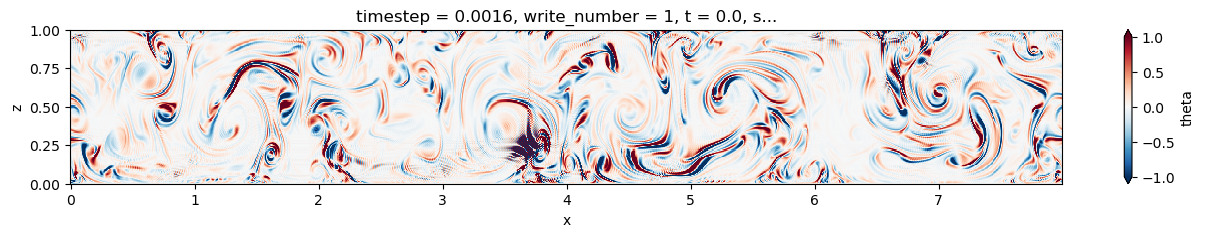

In [16]:
fine_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

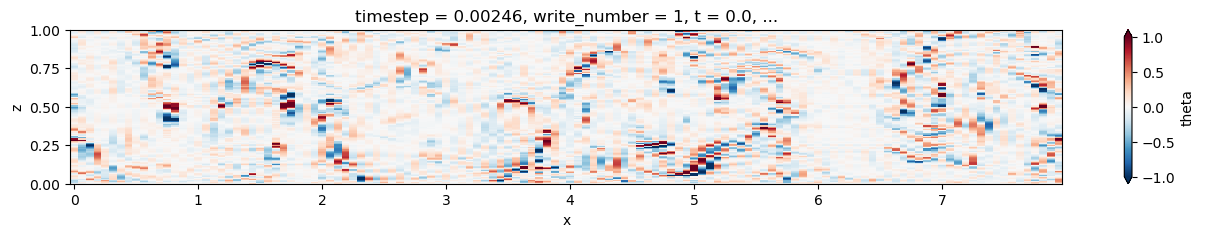

In [17]:
coarse_tend.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-1, vmax=1, cmap='RdBu_r')

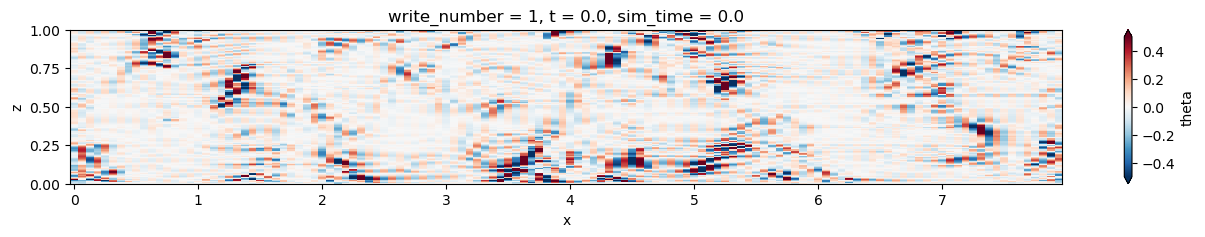

In [18]:
subgrid_tend.theta.isel(t=0).plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

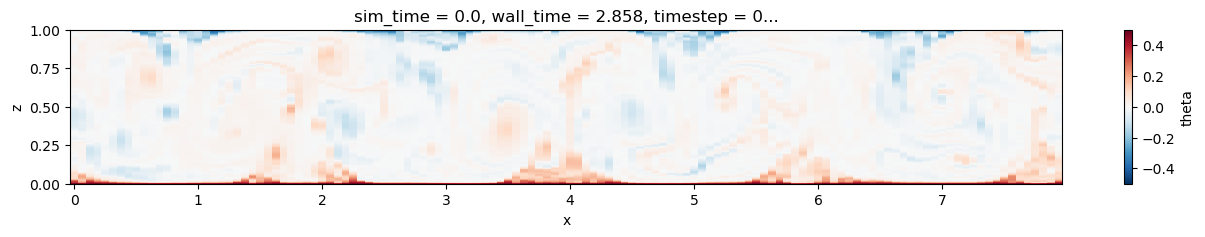

In [19]:
coarse_t.theta.isel(t=0).T.plot(figsize=(16,2), vmin=-0.5, vmax=0.5, cmap='RdBu_r')

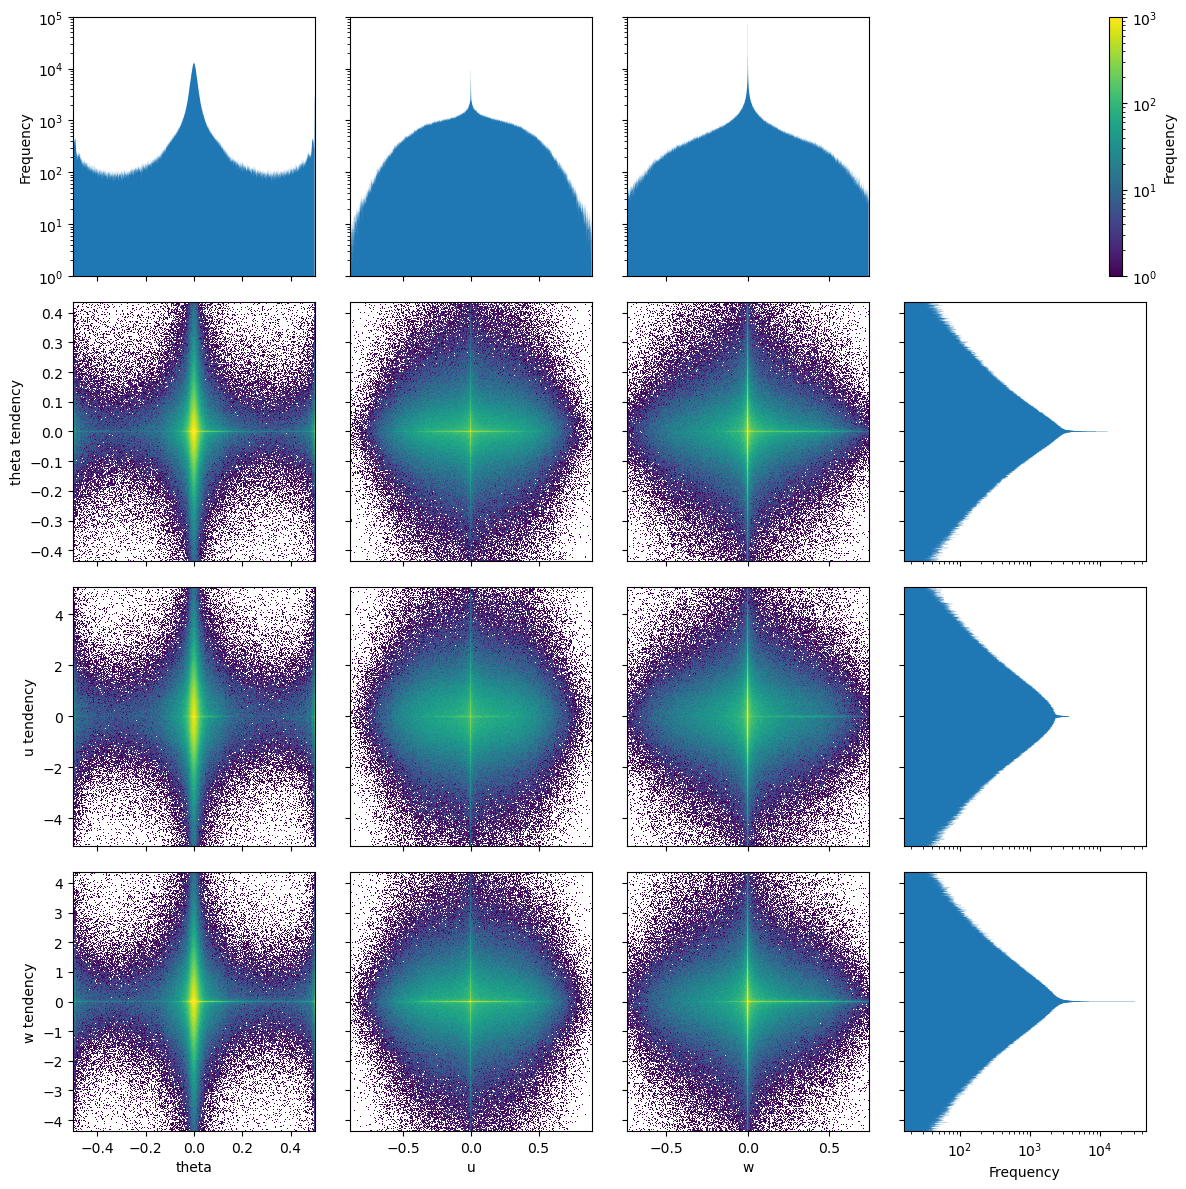

In [22]:
fig, axes = plt.subplots(4, 4, sharex='col', sharey='row', figsize=(12, 12))
hist1d_nbins = 4000
hist2d_nbins = 500
n_std = 3

for i, tend_var in enumerate(subgrid_tend.data_vars):
    tend_data = subgrid_tend[tend_var].data.ravel()
    tend_lim = n_std*tend_data.std()
    axes[i+1,0].set_ylabel(f'{tend_var} tendency')

    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].data.ravel().compute()
        if state_var == 'theta':
            state_lim = 0.5
        else:
            state_lim = n_std*state_data.std()

        _, _, _, hist = axes[i+1,j].hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e3
        )

        axes[i+1,3].hist(
            tend_data, bins=hist1d_nbins, orientation='horizontal',
            range=(-tend_lim, tend_lim), color='tab:blue',
            histtype='stepfilled', log=True
        )

        if i == 0:
            axes[0,j].hist(
                state_data, bins=hist1d_nbins,
                range=(-state_lim, state_lim), color='tab:blue',
                histtype='stepfilled', log=True
            )
            axes[0,j].set_ylim(1, 1e5)
            axes[-1,j].set_xlabel(state_var)

fig.colorbar(hist, ax=axes[0,-1], label='Frequency')
axes[0,0].set_ylabel('Frequency')
axes[-1,-1].set_xlabel('Frequency')
axes[0,3].remove()
fig.tight_layout()

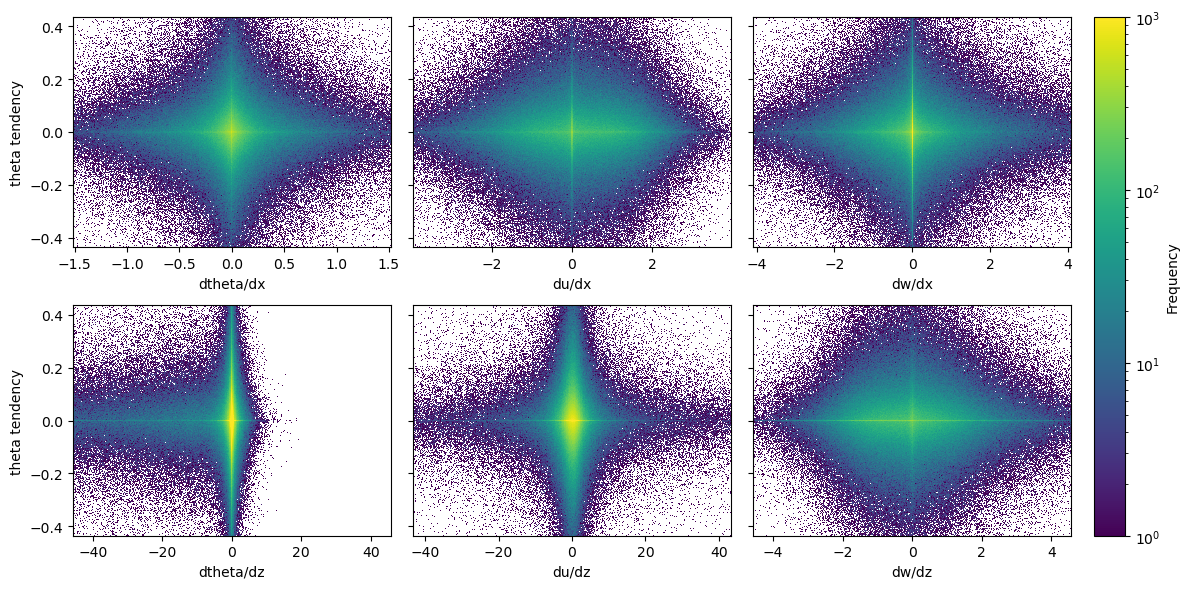

In [24]:
fig = plt.figure(figsize=(12, 6))
gs = mpl.gridspec.GridSpec(
    2, 4, height_ratios=[1, 1], width_ratios=[1, 1, 1, 0.1])
hist2d_nbins = 500
n_std = 3

tend_var = 'theta'
tend_data = subgrid_tend[tend_var].data.ravel()
tend_lim = n_std*tend_data.std()

for i, coord in enumerate(['x', 'z']):
    for j, state_var in enumerate(coarse_t.data_vars):
        state_data = coarse_t[state_var].differentiate(coord).data.ravel().compute()
        state_lim = n_std*state_data.std()

        ax = fig.add_subplot(gs[i,j])
        _, _, _, hist = ax.hist2d(
            state_data, tend_data, bins=[hist2d_nbins, hist2d_nbins],
            range=[[-state_lim, state_lim], [-tend_lim, tend_lim]],
            norm='log', vmin=1, vmax=1e3
        )

        ax.set_xlabel(f'd{state_var}/d{coord}')
        if j == 0:
            ax.set_ylabel(f'{tend_var} tendency')
        else:
            ax.set_yticklabels([])

ax = fig.add_subplot(gs[:,-1])
fig.colorbar(hist, cax=ax, label='Frequency')
fig.tight_layout()

## Proposal: LES instead of DNS
- I need a model that is more "well-behaved", especially at coarse resolution
- The dissipation is not strong enough to break down the eddies at the grid resolution
- The fine and coarse models could instead be LES models, where we introduce a simple resolution-dependent subgrid closure to artificially dissipate the smallest eddies
- The coarse model does not necessarily need to solve the same equations as the fine model
    - It should just be our current best estimate of the solution 

A simple closure that I could use is the Smagorinsky eddy viscosity model, which introduces a subgrid stress
$$
\tau_{ij}^\mathrm{sgs} = 2 \nu_\mathrm{sgs} S_{ij}^*
$$
where
$$
\nu_\mathrm{sgs} = (C_S \Delta)^2 \sqrt{2 S_{ij} S_{ij}}
$$
is the eddy viscosity and
$$
    S_{ij} = \frac{1}{2} \left( \frac{\partial u_i}{\partial x_j} + \frac{\partial u_j}{\partial x_i} \right)
$$
is the strain rate tensor, with deviatoric part
$$
    S_{ij}^* = S_{ij} - \frac{1}{3} S_{kk} \delta_{ij}.
$$